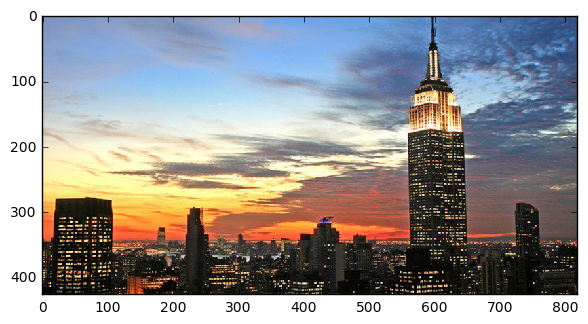

picture compressed using k-cluster with 2 colors


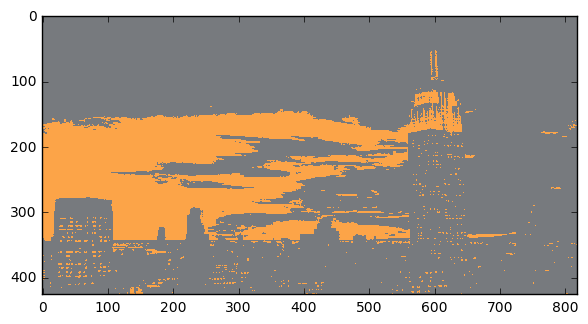

picture compressed using k-cluster with 16 colors


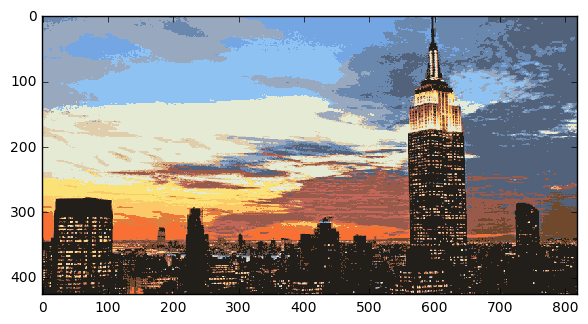

picture compressed using k-cluster with 32 colors


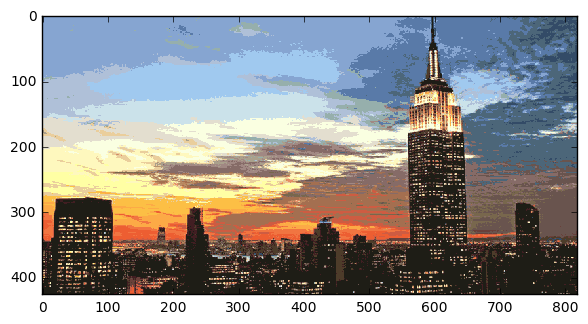

picture compressed using 32 random colors


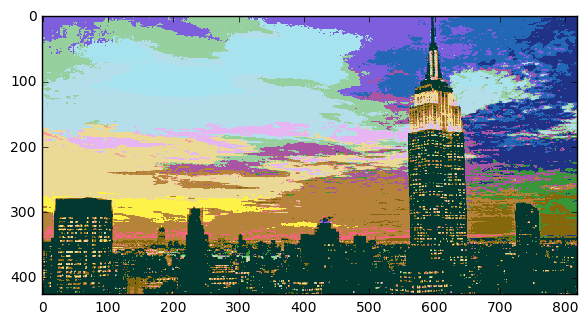

picture compressed using 32 randomly picked pixels as colors


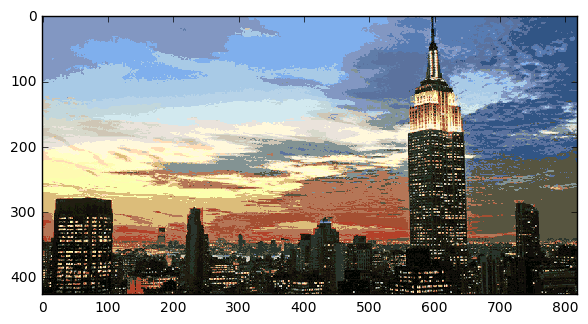

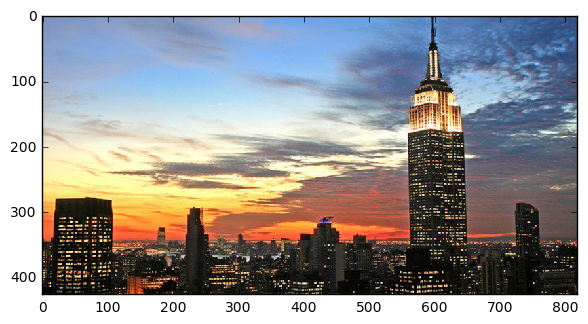

picture compressed using k-cluster with 32 colors


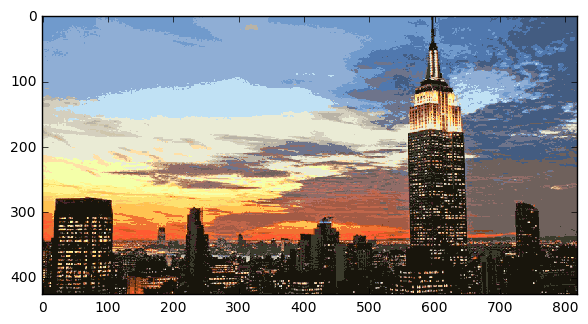

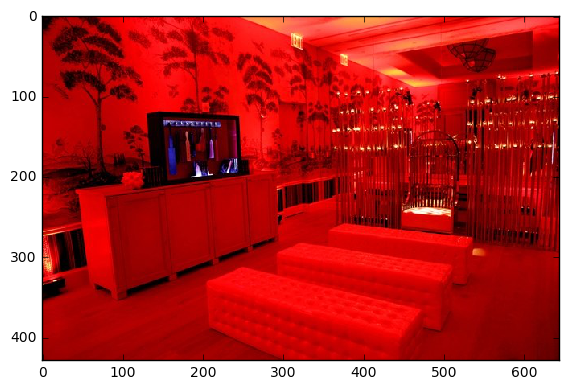

picture compressed using 32 random colors


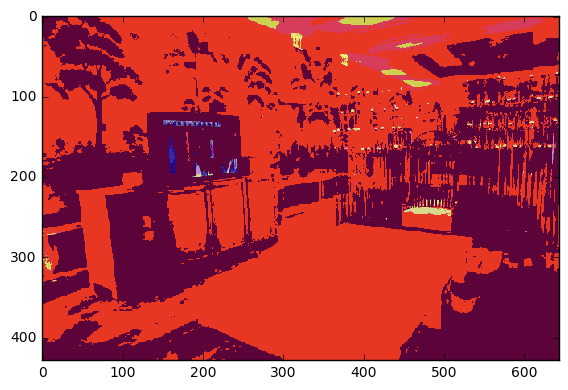

picture compressed using 32 randomly picked pixels as colors


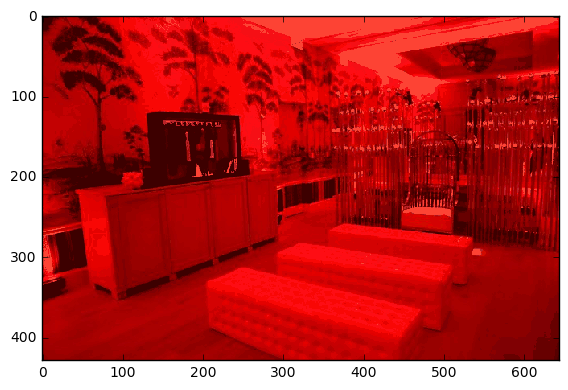

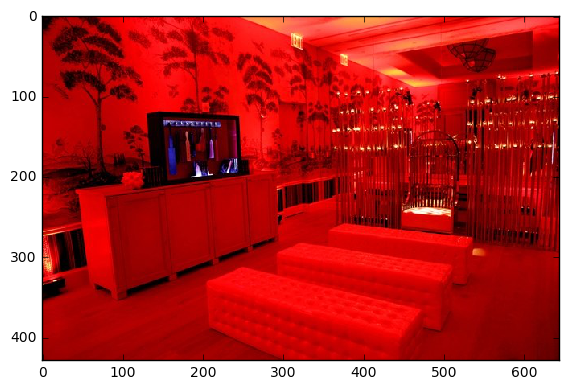

picture compressed using k-cluster with 32 colors


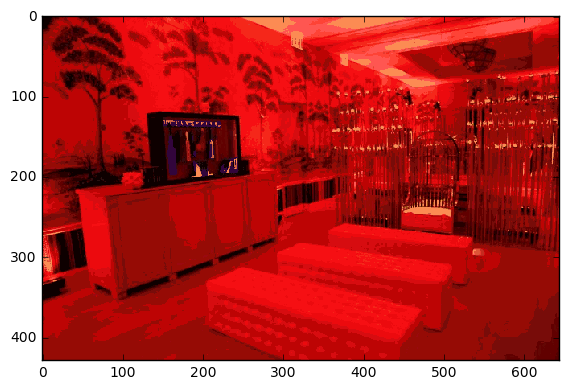

In [25]:
# This file contains the python code for
# 1) compressing an image using via k-clustering and Kruskal's algorithm
# 2) compressing an image selecting a random number of colors
# Author: Yuri Faenza, Columbia University - yf2414@columbia.edu


import numpy as np
import networkx as nx

import scipy.misc
import sys
from skimage import io
from random import randint
import matplotlib.image as img

from sklearn import cluster
from sklearn.utils import shuffle

# function computing the Euclidean distance between two vectors
# Input: vectors x and y of the same dimension
# Returns: the distance


def compute_distance (x,y):
    
    if len(x)== len(y):
        dist=0
        for i in range(len(x)):
            dist=dist+(x[i]-y[i])**2
        return dist**(.5)
    else:
        return -1

# function computing the point of a set closest to a given point
# Input: point x, list of points Y
# Return: point from Y that is closest to x

def closest_point(x,Y):
    
    distance=int(sys.maxsize)
    closest=-1
    
    for i in Y:
        candidate_dist=compute_distance(x,i)
        if candidate_dist < distance:
            distance=candidate_dist
            closest=i
    
    return closest

# function that computes the centroid of a set of n-dimensional points. 
# Input: a matrix X whose entry X[i][j] is the j-th coordinate of the i-th point
# Return: the coordinate vector of the centroid

def centroid(X):
    
    
    n=len(X) # number of elements in the set
    m= len(X[0]) # number of coordinates of each element   
    centr=[]
    
    for j in range(m):
        sum=0.0
        for i in range(n):
            sum=sum+X[i][j]
        sum=sum/n
        centr.append(sum)
    return centr
            
# functions that solves the k-clustering problem using the Kruskal-based algorithm
# Input: a graph G in Networkx format, the number of clusters k to produce
# Output 


def k_cluster(G,k):
    
# we sort the edges of the graph
    
    edge=sorted(G.edges(data=True), key=lambda x: x[2]['weight'])
    n=nx.number_of_nodes(G)
    
# let's run kruskal, stopping k-1 steps before the hand

# we create an auxiliary tree with all nodes, but no edge, and we add edges as Kruskal algorithm adds them

    Tree=nx.Graph()
    
    [Tree.add_node(i) for i in range(n)]
    
    
    counter=0
    
    for e in edge:
        u=e[0]
        v=e[1]
        if u not in nx.node_connected_component(Tree,v):
            Tree.add_edge(u,v)
            counter=counter+1
        if counter==n-k:
            break

 
 # we compute the connected components of the graph

    connected=[]
    
    for i in range(n):
        found=0
        for j in range(len(connected)):
            if i in nx.node_connected_component(Tree,connected[j][0]):
                connected[j].append(i)
                found=1
                break
        if found==0:
            connected.append([i])
    
    
    return connected




    
## function that compresses the image using Kruskal

def compress_image(im,nr_colors,nr_samples,ifprint):


# we first upload the image   

    image = io.imread(im)


# let's print the image we just opened

    if ifprint==1:
        io.imshow(image)
        io.show()

# we store the number of rows and of columns of the images (i.e., the image has `nrcols` pixels per row, and `nrrows` many rows)

    nrrows = image.shape[0]
    nrcols = image.shape[1]

    nrpixels=nrrows*nrcols


# each pixel is given as a tridimensional array. For instance, let's print out the array corresponding to the top-left pixel


# let's now create a graph whose entries are the randomly sampled pixels and whose distances are the distances of the corresponding vectors

    G=nx.Graph()
    
    for i in range(nr_samples):

        row = np.random.randint(nrrows)
        col = np.random.randint(nrcols)
        
        G.add_node(i,x=[float(image[row][col][0]),float(image[row][col][1]),float(image[row][col][2])])
        
    
        for j in range(i):
            G.add_edge(i,j,weight=compute_distance(G.node[i]['x'],G.node[j]['x']))
            
    
# create a list where each entry is a list of node in some connected component

    
    connected = k_cluster(G,nr_colors) 
    
    nr_components=len(connected)
    
    colors=[]
    
    for i in range(nr_components):
        X=[]
        for j in connected[i]:
            X.append(G.node[j]['x'])
        colors.append(centroid(X))
     
    compressed_image=image.copy()
 
 #    let's replace each pixel with the color from the selection that is closest to it
    
    for i in range(nrrows):
        for j in range(nrcols):
            compressed_image[i][j]=closest_point(image[i][j],colors)

    print("picture compressed using k-cluster with %s colors" % nr_colors)
 
 #    let's print and save the image
 
    io.imshow(compressed_image)
    io.show()
    
    scipy.misc.imsave('k-cluster_compression.jpg', compressed_image)

        
            
def random_compression(im,nr_colors,ifprint): 

# first part is as the previous one

    image = io.imread(im)

    if ifprint==1:
        io.imshow(image)
        io.show()

    nrrows = image.shape[0]
    nrcols = image.shape[1]

    nrpixels=nrrows*nrcols

# let's now create random colors

    colors=[]
    
    for i in range(nr_colors):
        x=np.random.randint(256)
        y=np.random.randint(256)
        z=np.random.randint(256)
        colors.append([float(x),float(y),float(z)])
     

    compressed_image=image.copy()
 
 # let's replace each pixel with the closest color among those that we sampled
    
    for i in range(nrrows):
        for j in range(nrcols):
            compressed_image[i][j]=closest_point(image[i][j],colors)

    print("picture compressed using %s random colors" % nr_colors)

    io.imshow(compressed_image)
    io.show()
    
    scipy.misc.imsave('random_compression.jpg', compressed_image)
        
            
def just_pick_compression(im,nr_colors,ifprint): 

# first part is as the previous one

    image = io.imread(im)

    if ifprint==1:
        
        print("original image")
        io.imshow(image)
        io.show()

    nrrows = image.shape[0]
    nrcols = image.shape[1]

    nrpixels=nrrows*nrcols

# let's now create random colors

    colors=[]
    
    for i in range(nr_colors):

        row = np.random.randint(nrrows)
        col = np.random.randint(nrcols)
        x=float(image[row][col][0])
        y=float(image[row][col][1])
        z=float(image[row][col][2])
        colors.append([x,y,z])
     

    compressed_image=image.copy()
 
 # let's replace each pixel with the closest color among those that we sampled
    
    for i in range(nrrows):
        for j in range(nrcols):
            compressed_image[i][j]=closest_point(image[i][j],colors)

    print("picture compressed using %s randomly picked pixels as colors" % nr_colors)

    io.imshow(compressed_image)
    io.show()
    
    scipy.misc.imsave('random_compression.jpg', compressed_image)

    
#### MAIN ####
    
  
file="Empire.jpg"
 
   
    
# Comparing compressing with 2, 16, and 32 colors    
    
compress_image(file,2,100,1)
compress_image(file,16,100,0)
compress_image(file,32,100,0)

# Comparing compressing with Kruskal, random colors, and randomly chosen pixels (16)

random_compression(file,32,0)
just_pick_compression(file,32,0)
compress_image(file,32,200,1)


# Comparing compressing with Kruskal, random colors, and randomly chosen pixels (16), a picture with shades of red

file="Glamour.jpg"

random_compression(file,32,1)
just_pick_compression(file,32,0)
compress_image(file,32,200,1)





In [27]:
# Print some parameters of the loaded picture

# Function that loads an image and prints some of the parameters

def test_image(im):

    image = io.imread(im)
    
# Print the RGB representation of all pixels

    print(image)
    
# Prints #rows, #columns, #primary colors used
    
    print(image.shape)
    

# Prints a pixel in position [20,40]

    print(image[20][40])


test_image(file)

[[[ 45   0   0]
  [ 51   0   0]
  [ 54   0   0]
  ..., 
  [252  26  28]
  [252  23  26]
  [252  23  26]]

 [[ 50   0   0]
  [ 61   5   6]
  [ 66  16  15]
  ..., 
  [255  30  32]
  [254  28  30]
  [255  26  29]]

 [[ 58   7   6]
  [ 62  12  11]
  [ 57  13  12]
  ..., 
  [255  30  36]
  [252  27  33]
  [252  25  32]]

 ..., 
 [[142   0   1]
  [142   0   1]
  [142   0   1]
  ..., 
  [ 79   0   3]
  [ 75   0   1]
  [ 75   0   1]]

 [[140   0   1]
  [142   0   1]
  [142   0   1]
  ..., 
  [ 78   0   2]
  [ 75   0   1]
  [ 74   0   0]]

 [[140   0   1]
  [140   0   1]
  [142   0   1]
  ..., 
  [ 78   0   2]
  [ 75   0   3]
  [ 74   0   2]]]
(429, 644, 3)
[34  0  0]
